In [1]:
import spacy
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import matplotlib.pyplot as plt
from keras.utils import plot_model,multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.models import load_model
from keras.layers import Input,GlobalAveragePooling2D,Layer,InputSpec
from keras.layers.core import Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
import keras.backend as K
import keras.layers as kl
from keras.preprocessing import sequence
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from time import time
import pickle
from keras.models import model_from_json

# from AttentionModule import SelfAttention, SoftAttention
import os
visible_gpu_devices = '1'
os.environ["CUDA_VISIBLE_DEVICES"]=visible_gpu_devices
import cv2
from tqdm.notebook import tqdm
import AttentionMed as AM
from importlib import reload
reload(AM)
from time import time,localtime,strftime
from ipywidgets import IntProgress
# from coord import CoordinateChannel2D

Using TensorFlow backend.


In [2]:
n_gpu=len(visible_gpu_devices.split(','))
n_cpu=1
tf_config= tf.ConfigProto(device_count = {'GPU': n_gpu , 'CPU': n_cpu})
tf_config.gpu_options.allow_growth=True
s=tf.Session(config=tf_config)
K.set_session(s)

In [3]:
timesteps = 40
vocab_size = 100
embedding_size = 300
elu_alpha = 1.0
bottleneck_units = 512
batchsize = 256
def temp_datagen(batchsize=1):
    counter=0
    while True:
        inp = np.random.randint(1,vocab_size,(batchsize,timesteps,))
        out = inp.copy()
        out[:,::2]=0
        out = np_utils.to_categorical(out,num_classes=101)
        counter+=1
        if batchsize==counter:
            yield inp,out
            counter=0
t_datagen = temp_datagen(batchsize)

In [4]:
t_x,t_y=next(t_datagen)
t_x[:2],t_y.argmax(-1),t_y.shape

(array([[61, 82, 46,  6, 69, 34, 30, 46, 18, 95, 48, 54,  1, 11, 41, 73,
         61, 74, 68, 29, 51, 61, 15, 73, 66, 56, 68, 68, 79, 65, 74,  3,
         40, 40, 91, 26, 92, 22, 62, 53],
        [41, 95, 95, 73, 72, 74, 78, 88, 72, 15, 93, 84, 97, 37, 90, 60,
         70,  1, 96, 67, 12, 84, 55, 82, 89,  7, 28, 34, 20, 70, 54, 94,
         86, 98, 74, 85, 15,  5,  2, 21]]),
 array([[ 0, 82,  0, ..., 22,  0, 53],
        [ 0, 95,  0, ...,  5,  0, 21],
        [ 0, 73,  0, ..., 46,  0, 77],
        ...,
        [ 0,  3,  0, ..., 37,  0, 51],
        [ 0,  3,  0, ..., 66,  0, 51],
        [ 0,  6,  0, ..., 70,  0, 19]]),
 (256, 40, 101))

In [11]:
units = 512

inp = kl.Input(shape=(timesteps,))
emb = kl.Embedding(vocab_size+1, embedding_size, mask_zero=False, name='w2v_emb')(inp)
encoder = kl.LSTM(units,activation='relu',return_sequences=True)(emb)
encoder = kl.BatchNormalization()(encoder)
# encoder,sa_maps = AM.SelfAttention(ch=512)(encoder)

# context_vector = kl.LSTM(512,activation='relu',return_sequences=False)(encoder)
context_vector = kl.GlobalAveragePooling1D(name='gap')(encoder)

acv_1,a_map_1 = AM.Attention(ch=512,timesteps=1,name='a1')([context_vector,encoder])
acv_1 = kl.BatchNormalization()(acv_1)

acv_2,a_map_2 = AM.Attention(ch=512,timesteps=1,name='a2')([context_vector,encoder])
acv_2 = kl.BatchNormalization()(acv_2)

acv_3,a_map_3 = AM.Attention(ch=512,timesteps=1,name='a3')([context_vector,encoder])
acv_3 = kl.BatchNormalization()(acv_3)

acv_4,a_map_4 = AM.Attention(ch=512,timesteps=1,name='a4')([context_vector,encoder])
acv_4 = kl.BatchNormalization()(acv_4)

acv_5,a_map_5 = AM.Attention(ch=512,timesteps=1,name='a5')([context_vector,encoder])
acv_5 = kl.BatchNormalization()(acv_5)

acv_6,a_map_6 = AM.Attention(ch=512,timesteps=1,name='a6')([context_vector,encoder])
acv_6 = kl.BatchNormalization()(acv_6)

acv_7,a_map_7 = AM.Attention(ch=512,timesteps=1,name='a7')([context_vector,encoder])
acv_7 = kl.BatchNormalization()(acv_7)

acv_8,a_map_8 = AM.Attention(ch=512,timesteps=1,name='a8')([context_vector,encoder])
acv_8 = kl.BatchNormalization()(acv_8)

concat_attention = kl.Concatenate(name='concat_attn')([acv_1,acv_2,acv_3,acv_4,acv_5,acv_6,acv_7,acv_8])
concat_attention = AM.CondenseAttention1D(ch_in=int(concat_attention.shape[-1]),ch_out=512)(concat_attention)
concat_attention = kl.Lambda(lambda x:K.squeeze(x,axis=1),name="attention_squeeze")(concat_attention)
concat_attention, g1, g2 = AM.ResidualCombine(method='add',name='residual_combine')([context_vector, concat_attention])
concat_attention = kl.BatchNormalization()(concat_attention)
# acv_combine = kl.Activation('relu')(concat_attention)
# acv_combine = kl.Lambda(lambda x:K.expand_dims(x,axis=1),name="Expand")(acv_combine)
# acv_combine = kl.Conv1D(filters=bottleneck_units,kernel_size=1,strides=1,padding='same')(acv_combine)
# acv_combine = kl.BatchNormalization()(acv_combine)
# acv_combine = kl.Lambda(lambda x:K.squeeze(x,axis=1),name="Squeeze2")(acv_combine)

# # # # print(attended_context_vector)
repeat_context_vector = kl.RepeatVector(n=timesteps)(concat_attention)
decoder = kl.LSTM(512,activation='relu',return_sequences=True)(repeat_context_vector)
# decoder = kl.BatchNormalization()(decoder)
# # AM.Attention(ch=1)([])
decoder_out = kl.TimeDistributed(Dense(vocab_size+1,activation='softmax'))(decoder)
model = Model(inp,decoder_out)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=Adam(lr=0.001))

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
w2v_emb (Embedding)             (None, 40, 300)      30300       input_4[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 40, 512)      1665024     w2v_emb[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 40, 512)      2048        lstm_7[0][0]                     
__________________________________________________________________________________________________
gap (Globa

In [14]:
# /media/MyDataStor1/mshaikh2/project_xray/notebooks
hist = model.fit_generator(t_datagen,epochs=100,verbose=1,steps_per_epoch=50)

Epoch 1/100
50/50 [==============================] - 9s 188ms/step - loss: 1.5930 - acc: 0.6060
Epoch 2/100
50/50 [==============================] - 9s 185ms/step - loss: 1.5715 - acc: 0.6088
Epoch 3/100
50/50 [==============================] - 9s 184ms/step - loss: 1.5495 - acc: 0.6128
Epoch 4/100
50/50 [==============================] - 9s 186ms/step - loss: 1.5357 - acc: 0.6136
Epoch 5/100
50/50 [==============================] - 9s 185ms/step - loss: 1.5220 - acc: 0.6150
Epoch 6/100
50/50 [==============================] - 9s 185ms/step - loss: 1.5122 - acc: 0.6159
Epoch 7/100
50/50 [==============================] - 9s 186ms/step - loss: 1.4997 - acc: 0.6171
Epoch 8/100
50/50 [==============================] - 9s 187ms/step - loss: 1.4892 - acc: 0.6178
Epoch 9/100
50/50 [==============================] - 9s 185ms/step - loss: 1.4783 - acc: 0.6191
Epoch 10/100
50/50 [==============================] - 9s 184ms/step - loss: 1.4643 - acc: 0.6212
Epoch 11/100
50/50 [===================

50/50 [==============================] - 9s 189ms/step - loss: 0.6662 - acc: 0.7788
Epoch 86/100
50/50 [==============================] - 10s 191ms/step - loss: 0.6667 - acc: 0.7783
Epoch 87/100
50/50 [==============================] - 9s 189ms/step - loss: 0.6563 - acc: 0.7811
Epoch 88/100
50/50 [==============================] - 10s 198ms/step - loss: 0.6418 - acc: 0.7852
Epoch 89/100
50/50 [==============================] - 10s 194ms/step - loss: 0.6353 - acc: 0.7867
Epoch 90/100
50/50 [==============================] - 9s 190ms/step - loss: 0.6246 - acc: 0.7908
Epoch 91/100
50/50 [==============================] - 9s 187ms/step - loss: 0.6209 - acc: 0.7911
Epoch 92/100
50/50 [==============================] - 9s 189ms/step - loss: 0.6119 - acc: 0.7940
Epoch 93/100
50/50 [==============================] - 9s 188ms/step - loss: 0.6026 - acc: 0.7966
Epoch 94/100
50/50 [==============================] - 9s 189ms/step - loss: 0.5918 - acc: 0.7997
Epoch 95/100
50/50 [====================

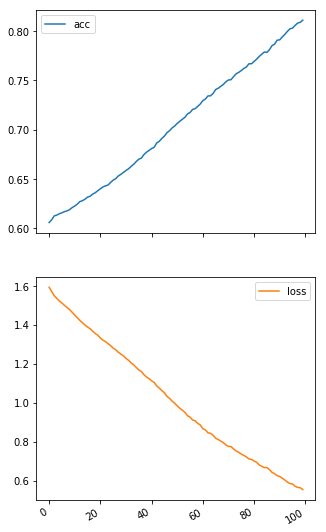

In [15]:
df = pd.DataFrame(hist.history)
df.to_csv("graphs/lstm_bn_gap_8attn_conv_bn_res_add_metrics.csv")
plot1,plot2 = df.plot(subplots=True, figsize=(5,10))
fig1 = plot1.get_figure()
fig2 = plot2.get_figure()
fig1.savefig("graphs/lstm_bn_gap_8attn_conv_bn_res_add_acc.png")
fig2.savefig("graphs/lstm_bn_gap_8attn_conv_bn_res_add_loss.png")